In [1]:
from __future__ import print_function
from glob import glob
from ROOT import vector, RDataFrame, RDF, TFile, TH1F, TH2F, gInterpreter, TMath
#import ROOT
import sys
import yaml
from src.RDF_tools.cpp_function import def_cpp
from src.general.utils import toVector, get_files, prep_filelist
import pandas as pd
from time import perf_counter
import uproot
from pathlib import Path
from os.path import exists
from src.general.make_noise import beep_on_error, beep_repeat
beep_on_error()

Welcome to JupyROOT 6.22/09


In [2]:
from src.RDF_tools.df_definitions import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Compile functions in c++ for the dataframe
def_cpp()

True

In [5]:
#set up multithreading
multiThreading = False
if multiThreading: 
    import ROOT
    ROOT.ROOT.EnableImplicitMT()
RDFrame = RDataFrame

In [6]:
output_dir = 'assets_feb_23'

In [7]:
#set up metadata for files
era = '2016'
deepflavour = False
deepcsv = True
extras = False
csv_v_flavor=False
if era == "2016":
    fname = "samplesCR_2016_Apr2020.yml"
    bDiscValue = 0.3093
if era == "2017":
    fname = "samplesCR_2017_Apr2020.yml"
    bDiscValue = 0.3033
if era == "2018":
    fname = "samplesCR_2018_Apr2020.yml"
    bDiscValue = 0.2770


sampleDir = "samples"
outname = fname.replace('.yml','.root')
fname = "{}/{}".format(sampleDir, fname)
outname, fname

('samplesCR_2016_Apr2020.root', 'samples/samplesCR_2016_Apr2020.yml')

In [8]:
from src.assets.bff_skimmer_bffv2 import *
columns_data, columns_mc, var_postfix = make_columns(era, columns_data)

In [9]:
columns_data

['Weight',
 'sample_weight',
 'TriggerWeight',
 'Flag_goodVertices',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_HBHENoiseFilter',
 'Flag_HBHENoiseIsoFilter',
 'Flag_EcalDeadCellTriggerPrimitiveFilter',
 'Flag_BadPFMuonFilter',
 'Flag_eeBadScFilter',
 'Flag_METFilters',
 'minGoodJetElDR_jet_nom_muon_corrected_pt_ele_pt',
 'minGoodJetMuDR_jet_nom_muon_corrected_pt_ele_pt',
 'DiLepMass_jet_nom_muon_corrected_pt_ele_pt',
 'HTLT_jet_nom_muon_corrected_pt_ele_pt',
 'RelMET_jet_nom_muon_corrected_pt_ele_pt',
 'TMB_jet_nom_muon_corrected_pt_ele_pt',
 'TMBMin_jet_nom_muon_corrected_pt_ele_pt',
 'TMBMax_jet_nom_muon_corrected_pt_ele_pt',
 'SR2_jet_nom_muon_corrected_pt_ele_pt',
 'SR1_jet_nom_muon_corrected_pt_ele_pt',
 'CR10_jet_nom_muon_corrected_pt_ele_pt',
 'CR11_jet_nom_muon_corrected_pt_ele_pt',
 'CR12_jet_nom_muon_corrected_pt_ele_pt',
 'CR13_jet_nom_muon_corrected_pt_ele_pt',
 'CR14_jet_nom_muon_corrected_pt_ele_pt',
 'SR2_jet_nom_muon_corrected_pt_ele_pt',
 'CR20_jet_nom_muon_correct

In [10]:
columns_mc

['Weight_PuUp',
 'Weight_PuDown',
 'Weight_BTagCorrUp',
 'Weight_BTagUncorrUp',
 'Weight_BTagCorrDown',
 'Weight_BTagUncorrDown',
 'Weight_PUIDUp',
 'Weight_PUIDDown',
 'Weight_PDF_Up',
 'Weight_PDF_Down',
 'Weight_ISRFSR_Up',
 'Weight_ISRFSR_Down',
 'Weight_MuonSFUp',
 'Weight_MuonSFDown',
 'Weight_ElectronSFUp',
 'Weight_ElectronSFDown',
 'Weight',
 'sample_weight',
 'TriggerWeight',
 'Flag_goodVertices',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_HBHENoiseFilter',
 'Flag_HBHENoiseIsoFilter',
 'Flag_EcalDeadCellTriggerPrimitiveFilter',
 'Flag_BadPFMuonFilter',
 'Flag_eeBadScFilter',
 'Flag_METFilters',
 'minGoodJetElDR_jet_nom_muon_corrected_pt_ele_pt',
 'minGoodJetMuDR_jet_nom_muon_corrected_pt_ele_pt',
 'DiLepMass_jet_nom_muon_corrected_pt_ele_pt',
 'HTLT_jet_nom_muon_corrected_pt_ele_pt',
 'RelMET_jet_nom_muon_corrected_pt_ele_pt',
 'TMB_jet_nom_muon_corrected_pt_ele_pt',
 'TMBMin_jet_nom_muon_corrected_pt_ele_pt',
 'TMBMax_jet_nom_muon_corrected_pt_ele_pt',
 'SR2_jet_nom_muon

In [11]:
sample_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bffv2/{}/{{}}'.format(era)
eff_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bff_eff/{}/{{}}'.format(era)

In [12]:
class sample_processor():
    '''Class that takes file name from yml and helps manage samples.'''
    def __init__(self,file_name,outname,bDiscValue,is_inclusive=0):
        #load config
        self.file_name = file_name
        with open(file_name,'r') as f:
            self.sample_dict = yaml.load(f, Loader=yaml.FullLoader)
        #setup outfile
        self.outname = outname
        self.out = TFile(outname, 'recreate')
        self.outdirs_dict = {}
        for sample in self.samples():
            name = sample['name']
            self.outdirs_dict[name] = self.out.mkdir(name)
        self.lumi = self.sample_dict['lumi']
        #get and write lumi info
        hlumi = TH1F("lumi", "lumi", 1, 0, 1)
        hlumi.SetDirectory(self.out)
        hlumi.SetBinContent(1, self.lumi)
        hlumi.Write()
        self.bDiscValue = bDiscValue
        self.is_inclusive = is_inclusive
    def samples(self):
        return self.sample_dict['samples']
    def sample_names(self):
        return [s['name'] for s in self.samples()]
    def close(self):
        self.out.Close()
    def __repr__(self):
        text_dict = {"fn":self.file_name,
                     "on":self.outname, 
                     "lumi":self.lumi,
                    "samples": self.sample_names()}
        return '''from {fn} to {on}\nlumi: {lumi}\nSamples {samples}'''.format(**text_dict)

In [13]:
fname

'samples/samplesCR_2016_Apr2020.yml'

In [14]:
# create instance of sample manager class 
sp = sample_processor(fname, outname, bDiscValue)
#print(sp)

In [15]:
sp

from samples/samplesCR_2016_Apr2020.yml to samplesCR_2016_Apr2020.root
lumi: 36.31
Samples ['y3_250_deepflavour_bff', 'y3_400_deepflavour_bff', 'y3_1000_deepflavour_bff', 'y3_700_deepflavour_bff', 'ST_t-channel_top_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1', 'ST_s-channel_4f_leptonDecays_13TeV-amcatnlo-pythia8_TuneCUETP8M1', 'WWZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 'ZZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 'WZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 'WWW_4F_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 'WJetsToQQ_HT-800toInf_qc19_3j_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'WJetsToQQ_HT-600ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'TTWJetsToQQ_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8', 'TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8', 'TTZToQQ_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 'TTZToLL_M-1to10_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8', 

In [16]:
# this creates long list of or statements for all permuations to select for events that are present in at least one region 
rs = ["CR10", "CR11", "CR12", "CR13", "CR14", "CR20", "CR21", "CR22", "CR23", "CR24", "SR1", "SR2"]

mcstring = ""
for jv in var_postfix:
    for r in rs:
        mcstring += "{}{} or ".format(r,jv)

JERC_var = ['jet_nom_muon_corrected_pt_ele_pt']
string = ""
for jv in JERC_var:
    for r in rs:
        string += "{}_{} or ".format(r,jv)
        mcstring += "{}_{} or ".format(r,jv)
data_region = string[:-3]
mc_region = mcstring[:-3]
#mc_region

In [17]:
def examine_sample(sp,sample,era,verbose=1, maxEvents=1e6):
    '''Process each sample and produced csv.'''
    #get metadata
    name,xsec,nEvents = sample['name'],sample['xsec'],sample['nevts']
    ismc,dirName = int(sample['ismc']),sample['fileglob']
    
    # get files fit for processing
    # filters out files that can't be opened, or are from old runs
    # then it selects a fewer number of files to open if there are too many files
    files_df = get_files(dirName, sample_path)
    
    files, nEvents = prep_filelist(files_df, ismc, verbose=True, maxEvents=maxEvents)
    #btageff file list
    bTagEffGlobName = eff_path.format(dirName)
    bTagEffGlobName = '/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bff_eff/2016/DYJetsToLL_M-200to400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8'
    eff_paths = list(Path(bTagEffGlobName).rglob('*.root'))+ list(Path(bTagEffGlobName+"_eff").rglob('*.root'))
    list_effs = list(map(lambda x: str(x), eff_paths))   
    # get n events from skim if 0
    sample_weight = float(xsec)*sp.lumi/float(nEvents)
 
    if verbose: print("name: {} , xsec: {}, nevents: {} ismc: {}, nfiles: {}".format(name,xsec,
                                                                                     nEvents,ismc,
                                                                                    len(files)))
    #set up btagging and puid sf files
    bTagFile, PUIDSFfile = setup_btag_puid(ismc, era, list_effs)
    #make rdf
    df = RDFrame('Events', files)
    if ismc:
        df = df.Range(0, int(maxEvents))
    df = df.Define("GenNsJets", "GetNsJets(GenPart_statusFlags, GenPart_pdgId)")
    df = df.Define("GenNbJets", "GetNbJets(GenPart_statusFlags, GenPart_pdgId)")    
    lcolumn = ['GenNbJets', 'GenNsJets']
    df_np = df.AsNumpy(lcolumn)
    df_df = pd.DataFrame(df_np)
    df_df.to_csv('{}/data/tw_{}_{}.csv'.format(output_dir, era,name))
    return name,df_df

In [18]:
def process_sample(sp,sample,era,verbose=1, maxEvents=1e6):
    '''Process each sample and produced csv.'''
    #get metadata
    name,xsec,nEvents = sample['name'],sample['xsec'],sample['nevts']
    ismc,dirName = int(sample['ismc']),sample['fileglob']
    
    # get files fit for processing
    # filters out files that can't be opened, or are from old runs
    # then it selects a fewer number of files to open if there are too many files
    files_df = get_files(dirName, sample_path)
    
    files, nEvents = prep_filelist(files_df, ismc, verbose=True, maxEvents=maxEvents)
    #btageff file list
    bTagEffGlobName = eff_path.format(dirName)
    bTagEffGlobName = '/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bff_eff/2016/DYJetsToLL_M-200to400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8'
    eff_paths = list(Path(bTagEffGlobName).rglob('*.root'))+ list(Path(bTagEffGlobName+"_eff").rglob('*.root'))
    list_effs = list(map(lambda x: str(x), eff_paths))   
    # get n events from skim if 0
    sample_weight = float(xsec)*sp.lumi/float(nEvents)
 
    if verbose: print("name: {} , xsec: {}, nevents: {} ismc: {}, nfiles: {}".format(name,xsec,
                                                                                     nEvents,ismc,
                                                                                    len(files)))
    #set up btagging and puid sf files
    bTagFile, PUIDSFfile = setup_btag_puid(ismc, era, list_effs)
    #make rdf
    df = RDFrame('Events', files)
    if ismc:
        df = df.Range(0, int(maxEvents))
    ##
    ## filter
    ##
    #df = df.Filter("DiLepMass_jet_nom_muon_corrected_pt_ele_pt>105", "mass_cut")
    #if ismc:
    #    df = df.Filter(mc_region, "in_region")
    #else:
    #    df = df.Filter(data_region, "in_region")
    #df = df.Filter("Flag_METFilters==1", "METFilter")    
    ##
    ## set up objects
    ##    
    var_string = '_jet_nom_muon_corrected_pt_ele_pt'
    df = def_good_leptons(df, ismc, era, var_string)
    ##
    ## set weights
    ##     
    df = def_HLT(df, ismc, era)
    df = bjet_weight(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = pdf_weight(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = fsr_isr_weight(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = muon_weight(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = electron_weight(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = k_factor(df,ismc, sp.is_inclusive, name, sample_weight, era)
    df = PU_weight(df,ismc, sp.is_inclusive, name, sample_weight, era, bDiscValue)
    df = finalize_weights(df,ismc, sp.is_inclusive, name, sample_weight, era)
    #gen inforamtion
    df = df.Define("GenMultiplicity", "GetGenMultiplicity(GenPart_statusFlags, GenPart_pdgId, GenPart_pt)")
    df = df.Define("GenNsJets", "GetNsJets(GenPart_statusFlags, GenPart_pdgId)")
    df = df.Define("GenNbJets", "GetNbJets(GenPart_statusFlags, GenPart_pdgId)")
    if ismc:
        df = df.Define("JER", "SysPercPerObj(Jet_pt_nom, Jet_pt_jerUp, Jet_pt_jerDown, 0)")
        df = df.Define("AvgJER", "clip(CalcAverage(JER))")
        df = df.Define("JES", "SysPercPerObj(Jet_pt_nom, Jet_pt_jesTotalUp, Jet_pt_jesTotalDown, 0)")
        df = df.Define("AvgJES", "CalcAverage(JES)")
        df = df.Define("HEM", "SysPercPerObj(Jet_pt_nom, Jet_pt_jesHEMIssueUp, Jet_pt_jesHEMIssueDown, 0)")
        df = df.Define("AvgHEM", "CalcAverage(HEM)")
    else:
        df = df.Define("JER", "1.")
        df = df.Define("AvgJER", "1.")
        df = df.Define("JES", "1.")
        df = df.Define("AvgJES", "1.")
        df = df.Define("HEM", "1.")
        df = df.Define("AvgHEM", "1.")     
    lcolumn = columns_mc
    if not ismc:
        lcolumn = columns_data
    lcolumn += ['PUIDWeight','PUIDWeightUp','PUIDWeightDown',
                'MuonTriggerEff', 'Weight_MuonTriggerUp', 'Weight_MuonTriggerDown',
                'genWeight'
                ,'k_factor'
                ,'puWeight'
                ,'PUIDWeight'
                ,'MuonSFweight'
                ,'ElectronSFweight'
                ,'TriggerWeight'
                ,'AvgMuonRecoIdIsoSFPerMuon'
                ,'AvgMuonRocPer',
               'AvgJER', 'AvgJES', 'AvgHEM',
                'AvgPUIDWeightsPerJet',
                'AvgBtagWeightCorr',
                'AvgBtagWeightUncorr', 'GenNbJets', 'GenNsJets', 'GenMultiplicity'
               ]
    df_np = df.AsNumpy(lcolumn)
    df_df = pd.DataFrame(df_np)
    df_df.to_csv('{}/data_gen_b_s/tw_{}_{}.csv'.format(output_dir, era,name))
    return name,df_df

In [36]:
failed_files = []
existing_files = []

for sample in sp.samples():
    name = sample['name']
    maxEvents=int(2e10) if (('ZTo' in name) or ('DY' in name)) else int(1e7)
    #maxEvents=int(1000)
    if not 'BFF' in name: continue
    #if not '0p5' in name: continue
    #if not '200' in name: continue
    print(name, maxEvents)
    #if  'y3' in name: continue
    start_time = perf_counter()
    outname = '{}/data_gen_b_s/tw_{}_{}.csv'.format(output_dir, era,sample['name'])
    try:
        name,df = process_sample(sp,sample,era, verbose=1, maxEvents=maxEvents)
        if not exists(outname):
            print("running......")
            name,df = process_sample(sp,sample,era, verbose=1, maxEvents=maxEvents)
        else:
            print("exits.......")
            existing_files.append(outname)
    except Exception as err:
        failed_files.append(outname)
        print(err)

    #count = df.Count()
    end_time = perf_counter()
    print("sample {} took {:.1f} seconds".format(name,end_time-start_time))

sp.close()

y3_250_deepflavour_bff 10000000
23 out of 23 files selected, 100.0% of events
name: y3_250_deepflavour_bff , xsec: 10.1, nevents: 454000.0 ismc: 1, nfiles: 23


KeyboardInterrupt: 

In [29]:
existing_files

['assets_feb_23/data_gen_b_s/tw_2016_BFFZprimeToMuMu_M_200_dbs0p5.csv']

In [30]:
failed_files

[]

In [49]:
beep_repeat()

KeyboardInterrupt: 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
path = 'assets_feb_23/data_gen_b_s/tw_2016_BFFZprimeToMuMu_M_200_dbs0p5.csv'
df = pd.read_csv(path)

In [32]:
for x in df:
    print(x)

Unnamed: 0
Weight_PuUp
Weight_PuDown
Weight_BTagCorrUp
Weight_BTagUncorrUp
Weight_BTagCorrDown
Weight_BTagUncorrDown
Weight_PUIDUp
Weight_PUIDDown
Weight_PDF_Up
Weight_PDF_Down
Weight_ISRFSR_Up
Weight_ISRFSR_Down
Weight_MuonSFUp
Weight_MuonSFDown
Weight_ElectronSFUp
Weight_ElectronSFDown
Weight
sample_weight
TriggerWeight
Flag_goodVertices
Flag_globalSuperTightHalo2016Filter
Flag_HBHENoiseFilter
Flag_HBHENoiseIsoFilter
Flag_EcalDeadCellTriggerPrimitiveFilter
Flag_BadPFMuonFilter
Flag_eeBadScFilter
Flag_METFilters
minGoodJetElDR_jet_nom_muon_corrected_pt_ele_pt
minGoodJetMuDR_jet_nom_muon_corrected_pt_ele_pt
DiLepMass_jet_nom_muon_corrected_pt_ele_pt
HTLT_jet_nom_muon_corrected_pt_ele_pt
RelMET_jet_nom_muon_corrected_pt_ele_pt
TMB_jet_nom_muon_corrected_pt_ele_pt
TMBMin_jet_nom_muon_corrected_pt_ele_pt
TMBMax_jet_nom_muon_corrected_pt_ele_pt
SR2_jet_nom_muon_corrected_pt_ele_pt
SR1_jet_nom_muon_corrected_pt_ele_pt
CR10_jet_nom_muon_corrected_pt_ele_pt
CR11_jet_nom_muon_corrected_pt_ele_

In [33]:
df.shape

(1000, 209)

In [34]:
tdf = df
tdf

,Unnamed: 0,Weight_PuUp,Weight_PuDown,Weight_BTagCorrUp,Weight_BTagUncorrUp,Weight_BTagCorrDown,Weight_BTagUncorrDown,Weight_PUIDUp,Weight_PUIDDown,Weight_PDF_Up,...,AvgMuonRocPer,AvgJER,AvgJES,AvgHEM,AvgPUIDWeightsPerJet,AvgBtagWeightCorr,AvgBtagWeightUncorr,GenNbJets,GenNsJets,GenMultiplicity
0,0,23.671816,19.311335,21.750063,21.750063,21.750063,21.750063,22.410172,21.089953,21.944545,...,0.000567,0.003532,0.015571,0.000000,0.029340,NaN,NaN,1,1,0
1,1,17.490063,19.574487,18.533899,18.533899,18.533899,18.533899,16.675980,20.409414,18.645324,...,0.000731,0.029897,0.031095,0.014286,-0.047050,NaN,NaN,1,1,0
2,2,22.042482,29.432233,25.824562,25.824562,25.824562,25.824562,25.824562,25.824562,26.018829,...,0.000399,0.002458,0.018618,0.000000,NaN,NaN,NaN,1,1,0
3,3,22.420699,20.779294,21.856271,21.856271,21.856271,21.856271,21.856271,21.856271,22.220787,...,0.000640,0.015173,0.020239,0.000000,NaN,NaN,NaN,1,1,0
4,4,19.235945,22.462670,20.937420,20.937420,20.937420,20.937420,20.937420,20.937420,21.108022,...,0.002091,0.014412,0.012226,0.000000,NaN,NaN,NaN,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,23.172640,11.774799,17.431480,17.365232,17.005583,17.071831,17.218532,17.218532,17.259255,...,0.000640,0.049573,0.036619,0.000000,NaN,-0.006184,-0.004260,2,2,3
996,996,21.894801,27.013579,24.595652,24.595652,24.595652,24.595652,24.595652,24.595652,24.835844,...,0.000719,0.016350,0.033253,0.000000,NaN,NaN,NaN,2,0,0
997,997,21.152153,23.673017,22.414548,22.414548,22.414548,22.414548,22.414548,22.414548,22.647121,...,0.000613,0.021127,0.032028,0.000000,NaN,NaN,NaN,2,0,0
998,998,13.889495,4.556526,8.599521,8.599521,8.599521,8.599521,8.599521,8.599521,8.743074,...,0.000304,0.059925,0.037180,0.000000,NaN,NaN,NaN,1,1,0


array([0.005, 0.836, 0.135, 0.015, 0.003, 0.006])

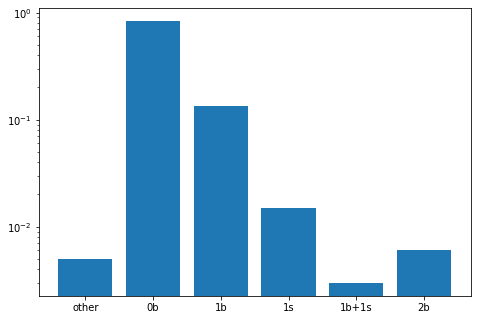

In [35]:
hist  = np.histogram(tdf.GenMultiplicity, bins=np.linspace(-1.5, 4.5, 7), density=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
students = [23,17,35,29,12]
ax.bar(['other', '0b', '1b', '1s', '1b+1s', '2b'], hist[0])

plt.yscale('log')
hist[0]

In [30]:
[0.005, 0.864, 0.1  , 0.024, 0.004, 0.003]

[0.005, 0.864, 0.1, 0.024, 0.004, 0.003]

Text(0.5, 1.0, 'Pre-selection')

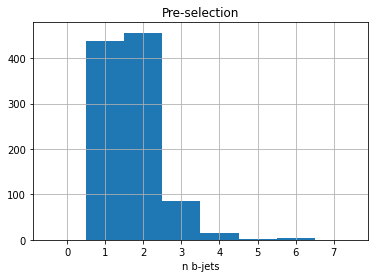

In [29]:
tdf.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('Pre-selection')


Text(0.5, 1.0, 'Pre-selection')

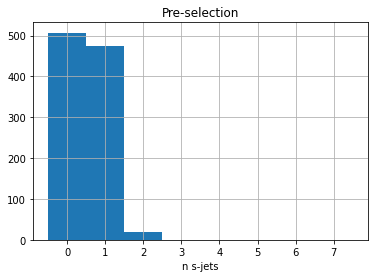

In [72]:
tdf.GenNsJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n s-jets')
plt.title('Pre-selection')


In [56]:
tdf = df[df.SR1_jet_nom_muon_corrected_pt_ele_pt==1]

Text(0.5, 1.0, 'SR1')

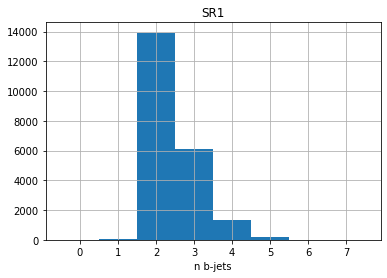

In [57]:
tdf.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('SR1')


Text(0.5, 1.0, 'SR1')

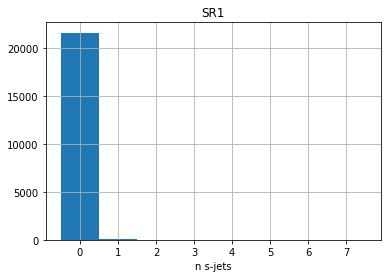

In [58]:
tdf.GenNsJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n s-jets')
plt.title('SR1')

In [59]:
np.histogram(tdf.GenNsJets, bins=np.linspace(-.5,7.5, 9))

(array([21593,    70,     2,     3,     0,     0,     0,     0]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]))

In [60]:
tdf = df[df.SR2_jet_nom_muon_corrected_pt_ele_pt==1]

Text(0.5, 1.0, 'SR2')

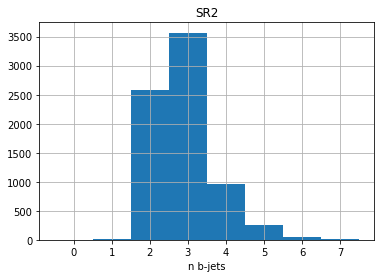

In [61]:
tdf.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('SR2')

Text(0.5, 1.0, 'SR2')

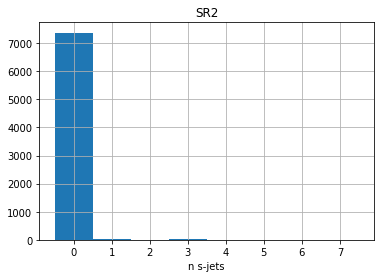

In [62]:
tdf.GenNsJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n s-jets')
plt.title('SR2')

In [63]:
df.Weight_MuonTriggerUp.mean()*100

0.07491169009413987

In [ ]:
df.Weight_BTagUp.mean()*100

In [ ]:
import uproot as upr

In [ ]:
skim_path = '/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bffv2/2017/BFF_175_dbs0p5_deepflavour_bffv2/221019_071128/0000/tree_1.root'

In [ ]:
upf = upr.open(skim_path)['Events']

In [ ]:
upf.arrays(['Muon_effSF_sys_triggerUp',
           'Muon_effSF_trigger',
           'Muon_effSF_sys_triggerDown'], library='pd').mean()

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('data/tw_2016_BFFZprimeToMuMu_M_250_dbs0p04.csv')

In [ ]:
[x for x in df.keys() if 'HLT' in x], [x for x in df.keys() if 'SR' in x]

In [ ]:
df.SR2_jet_nom_muon_corrected_pt_ele_pt.sum(), (df.SR2_jet_nom_muon_corrected_pt_ele_pt*df.HLT_Mu50).sum()

In [ ]:
df[[ 
    'MuonTriggerEff', 'Weight_MuonTriggerUp', 'Weight_MuonTriggerDown'
    ,'AvgMuonRecoIdIsoSFPerMuon'
                ,'AvgMuonRocPer',
               'AvgJER', 'AvgJES', 'AvgHEM',
                'AvgPUIDWeightsPerJet', 'AvgBtagWeight']].mean()*100

In [ ]:
df.AvgJER.mean()

In [ ]:
from src.data_tools.get_file_list import get_file_df


In [ ]:
era = 2016
file_df = get_file_df()
file_df = file_df[file_df.era==era]
file_df.reset_index(inplace=True)

In [ ]:
means_list = []
for i, x in file_df.iterrows():
    print(x.file)
    _df = pd.read_csv(x.file)
    _df = _df[_df.AvgJER<5]
    means = _df[[ 
    'MuonTriggerEff', 'Weight_MuonTriggerUp', 'Weight_MuonTriggerDown'
    ,'AvgMuonRecoIdIsoSFPerMuon'
                ,'AvgMuonRocPer',
               'AvgJER', 'AvgJES', 'AvgHEM',
                'AvgPUIDWeightsPerJet', 'AvgBtagWeight']].mean()*100
    means_dict = means.to_dict()
    means_dict['mass'] = x.mass
    means_dict['dbs'] = x.dbs
    means_list.append(means_dict)

In [ ]:
mean_df = pd.DataFrame(means_list)

In [ ]:
mean_df.min().round(1)

In [ ]:
mean_df.max().round(1)

In [ ]:
import numpy as np

In [ ]:
mean_df.AvgJER